```
Project:  Project 2: Luther
Date:     02/03/2017
Name:     Prashant Tatineni
```

# Project Overview
For Project Luther, I gathered the set of all films listed under movie franchises on boxofficemojo.com. My goal was to predict the success of a movie sequel (i.e., domestic gross in USD) based on the performance of other sequels, and especially based on previous films in that particular franchise. I saw some linear correlation between certain variables, like number of theaters, and the total domestic gross, but the predictions from my final model were not entirely reasonable. More time could be spent on better addressing the various outliers in the dataset.

# Summary of Solution Steps
1. Retrieve data from boxofficemojo.com.
2. Clean up data and reduce to a set of predictor variables, with "Adjusted Gross" as the target for prediction.
3. Run Linear Regression model.
4. Review model performance.

In [978]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import requests
from bs4 import BeautifulSoup
import dateutil.parser
import statsmodels.api as sm
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import sys, sklearn
from sklearn import linear_model, preprocessing
from sklearn import metrics

%matplotlib inline

## Step 1
I started with the "Franchises" list on Boxofficemojo.com. Within each franchise page, I scraped each movie's information and enter it into a Python dictionary. If it's already in the dictionary, the entry will be overwritten, except with a different Franchise name. But note below that the url for "Franchises" list was sorted Ascending, so this conveniently rolls "subfranchises" into their "parent" franchise.

E.g., "Fantastic Beasts" and the "Harry Potter" movies have their own separate Franchises, but they will all be tagged as the "JKRowling" franchise, i.e. "./chart/?id=jkrowling.htm"

Also, because I was comparing sequels to their predecessors, I focused on Domestic Gross, adjusted for ticket price inflation.

In [75]:
url = 'http://www.boxofficemojo.com/franchises/?view=Franchise&sort=nummovies&order=ASC&p=.htm'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")
tables = soup.find_all("table")
rows = [row for row in tables[3].find_all('tr')]
rows = rows[1:]

In [900]:
# Initialize empty dictionary of movies
movies = {}

for row in rows:
    items = row.find_all('td')
    franchise = items[0].find('a')['href']
    franchiseurl = 'http://www.boxofficemojo.com/franchises/' + franchise[2:]
    response = requests.get(franchiseurl)
    
    franchise_page = response.text
    franchise_soup = BeautifulSoup(franchise_page,"lxml")
    franchise_tables = franchise_soup.find_all("table")
    franchise_gross = [row for row in franchise_tables[4].find_all('tr')]
    franchise_gross = franchise_gross[1:len(franchise_gross)-2]
    franchise_adjgross = [row for row in franchise_tables[5].find_all('tr')]
    franchise_adjgross = franchise_adjgross[1:len(franchise_adjgross)-2]

    # Assign movieurl as key
    # Add title, franchise, inflation-adjusted gross, release date.
    for row in franchise_adjgross:
        movie_info = row.find_all('td')
        movieurl = movie_info[1].find('a')['href']
        title = movie_info[1]
        adjgross = movie_info[3]
        release = movie_info[5]
        movies[movieurl] = [title.text]
        movies[movieurl].append(franchise) 
        movies[movieurl].append(adjgross.text)  
        movies[movieurl].append(release.text)
    
    # Add number of theaters for the above movies
    for row in franchise_gross:
        movie_info = row.find_all('td')
        movieurl = movie_info[1].find('a')['href']
        theaters = movie_info[4]
        if movieurl in movies.keys():
            movies[movieurl].append(theaters.text)

In [901]:
df = pd.DataFrame(movies.values())
df.columns = ['Title','Franchise', 'AdjGross', 'Release', 'Theaters']
df.head()

,Title,Franchise,AdjGross,Release,Theaters
0,Tyler Perry's Madea Goes to Jail,./chart/?id=madea.htm,"$109,038,600",2/20/09,"2,203"
1,Scary Movie 4,./chart/?id=scarymovie.htm,"$119,793,400",4/14/06,"3,674"
2,Fantastic Four (2005),./chart/?id=fantasticfour.htm,"$208,755,300",7/8/05,"3,619"
3,The Amazing Spider-Man,./chart/?id=spiderman.htm,"$291,314,200",7/3/12,"4,318"
4,A Nightmare on Elm Street,./chart/?id=nightmareonelmstreet.htm,"$63,139,700",11/9/84,380


In [902]:
df.shape

(736, 5)

## Step 2
Clean up data.

In [903]:
# Remove movies that were re-issues, special editions, or separate 3D or IMAX versions.
df['Ignore'] = df['Title'].apply(lambda x: 're-issue' in x.lower()  or 're-release' in x.lower()  or 'special edition' in x.lower() or '3d)' in x.lower() or 'imax' in x.lower())
df = df[(df.Ignore == False)]
del df['Ignore']
df.shape

(713, 5)

In [905]:
# Convert Adjusted Gross to a number
df['AdjGross'] = df['AdjGross'].apply(lambda x: int(x.replace('$','').replace(',','')))

# Convert Date string to dateobject. Need to prepend '19' for dates > 17 because Python treats '/60' as year '2060'
df['Release'] = df['Release'].apply(lambda x: (x[:-2] + '19' + x[-2:]) if int(x[-2:]) > 17 else x)
df['Release'] = df['Release'].apply(lambda x: dateutil.parser.parse(x))

The films need to be grouped by franchise so that franchise-related data can be included as featured for each observation.
- The Average Adjusted Gross of all previous films in the franchise
- The Adjusted Gross of the very first film in the franchise
- The Release Date of the previous film in the franchise
- The Release Date of the very first film in the franchise
- The Series Number of the film in that franchise  
-- I considered using the film's number in the franchise as a rank value that could be split into indicator variables, but it's useful as a linear value because the total accrued sum of $ earned by the franchise is a linear combination of "SeriesNum" and "PrevAvgGross"

In [908]:
df = df.sort_values(['Franchise','Release'])
df['CumGross'] = df.groupby(['Franchise'])['AdjGross'].apply(lambda x: x.cumsum())
df['SeriesNum'] = df.groupby(['Franchise'])['Release'].apply(lambda x: x.rank())
df['PrevAvgGross'] = (df['CumGross'] - df['AdjGross'])/(df['SeriesNum'] - 1)

- Number of Theaters in which the film showed  
-- Where this number was unavailable, replaced '-' with 0; the 0 will later be replaced with the mean number of theaters for the other films in the same franchise. I chose the average as a reasonable estimate.

In [910]:
df.Theaters = df.Theaters.replace('-','0')
df['Theaters'] = df['Theaters'].apply(lambda x: int(x.replace(',','')))

In [911]:
df['PrevRelease'] = df['Release'].shift()

# Create a second dataframe with franchise group-related information.
df_group = pd.DataFrame(df.groupby(['Franchise'])['Title'].apply(lambda x: x.count()))
df_group['FirstGross'] = df.groupby(['Franchise'])['AdjGross'].first()
df_group['FirstRelease'] = df.groupby(['Franchise'])['Release'].first()
df_group['SumTheaters'] = df.groupby(['Franchise'])['Theaters'].apply(lambda x: x.sum())

In [912]:
df_group.columns = ['NumOfFilms','FirstGross','FirstRelease','SumTheaters']
df_group['AvgTheaters'] = df_group['SumTheaters']/df_group['NumOfFilms']

In [913]:
df_group['Franchise'] = df.groupby(['Franchise'])['Franchise'].first()

In [914]:
df = df.merge(df_group, on='Franchise')

In [915]:
df.head()

,Title,Franchise,AdjGross,Release,Theaters,CumGross,SeriesNum,PrevAvgGross,PrevRelease,NumOfFilms,FirstGross,FirstRelease,SumTheaters,AvgTheaters
0,3 Ninjas,./chart/?id=3ninjas.htm,60446400,1992-08-07,1954,60446400,1.0,NaN,NaT,4,60446400,1992-08-07,4169,1042.250000
1,3 Ninjas Kick Back,./chart/?id=3ninjas.htm,24416300,1994-05-06,2043,84862700,2.0,6.044640e+07,1992-08-07,4,60446400,1992-08-07,4169,1042.250000
2,3 Ninjas Knuckle Up,./chart/?id=3ninjas.htm,822200,1995-03-10,52,85684900,3.0,4.243135e+07,1994-05-06,4,60446400,1992-08-07,4169,1042.250000
3,3 Ninjas: High Noon at Mega Mountain,./chart/?id=3ninjas.htm,693100,1998-04-10,120,86378000,4.0,2.856163e+07,1995-03-10,4,60446400,1992-08-07,4169,1042.250000
4,Kiss the Girls,./chart/?id=alexcross.htm,114066700,1997-10-03,2406,114066700,1.0,NaN,1998-04-10,3,114066700,1997-10-03,7520,2506.666667


In [916]:
df['Theaters'] = df.Theaters.replace(0,df.AvgTheaters)

In [917]:
# Drop rows with NaN. Drops all first films, but I've already stored first film information within other features.
df = df.dropna()
df.shape

(543, 14)

In [918]:
df['DaysSinceFirstFilm'] = df.Release - df.FirstRelease
df['DaysSinceFirstFilm'] = df['DaysSinceFirstFilm'].apply(lambda x: x.days)

In [919]:
df['DaysSincePrevFilm'] = df.Release - df.PrevRelease
df['DaysSincePrevFilm'] = df['DaysSincePrevFilm'].apply(lambda x: x.days)

In [922]:
df.sort_values('Release',ascending=False).head()

,Title,Franchise,AdjGross,Release,Theaters,CumGross,SeriesNum,PrevAvgGross,PrevRelease,NumOfFilms,FirstGross,FirstRelease,SumTheaters,AvgTheaters,DaysSinceFirstFilm,DaysSincePrevFilm
530,Resident Evil: The Final Chapter,./chart/?id=residentevil.htm,16634600,2017-01-27,3104.0,323867200,6.0,61446520.0,2012-09-14,6,59730700,2002-03-15,17989,2998.166667,5432,1596
712,xXx: The Return of Xander Cage,./chart/?id=xxxtrilogy.htm,35814600,2017-01-20,3651.0,283638200,3.0,123911800.0,2005-04-29,3,211558500,2002-08-09,10667,3555.666667,5278,4284
676,Underworld: Blood Wars,./chart/?id=underworld.htm,29756100,2017-01-06,3070.0,308546300,5.0,69697550.0,2012-01-20,5,74535000,2003-09-19,15225,3045.000000,4858,1813
621,Rogue One: A Star Wars Story,./chart/?id=starwars.htm,515381200,2016-12-16,4157.0,5807058000,9.0,661459600.0,2015-12-18,9,1234649200,1977-05-25,26485,2942.777778,14450,364
335,Fantastic Beasts and Where To Find Them,./chart/?id=jkrowling.htm,228705500,2016-11-18,4144.0,3291503100,9.0,382849700.0,2011-07-15,9,483647300,2001-11-16,36451,4050.111111,5481,1953


For the regression model, I decided to keep data for films released through 2016, but drop the 3 films released this year; because of their recent release date, their gross earnings will not yet be representative.

In [923]:
films17 = df.loc[[530,712,676]]

In [1008]:
# Grabbing columns for regression model and dropping 2017 films
dfreg = df[['AdjGross','Theaters','SeriesNum','PrevAvgGross','FirstGross','DaysSinceFirstFilm','DaysSincePrevFilm']]
dfreg = dfreg.drop([530,712,676])
dfreg.shape

(540, 7)

## Step 3
Apply Linear Regression.

In [929]:
dfreg.corr()

,AdjGross,Theaters,SeriesNum,PrevAvgGross,FirstGross,DaysSinceFirstFilm,DaysSincePrevFilm
AdjGross,1.000000,0.493283,0.094456,0.667062,0.558083,0.025915,-0.049429
Theaters,0.493283,1.000000,0.158827,0.290426,0.242405,0.237296,0.144122
SeriesNum,0.094456,0.158827,1.000000,0.038785,0.053518,0.634191,-0.042277
PrevAvgGross,0.667062,0.290426,0.038785,1.000000,0.892891,0.005214,-0.056587
FirstGross,0.558083,0.242405,0.053518,0.892891,1.000000,0.128245,0.030852
DaysSinceFirstFilm,0.025915,0.237296,0.634191,0.005214,0.128245,1.000000,0.526116
DaysSincePrevFilm,-0.049429,0.144122,-0.042277,-0.056587,0.030852,0.526116,1.000000


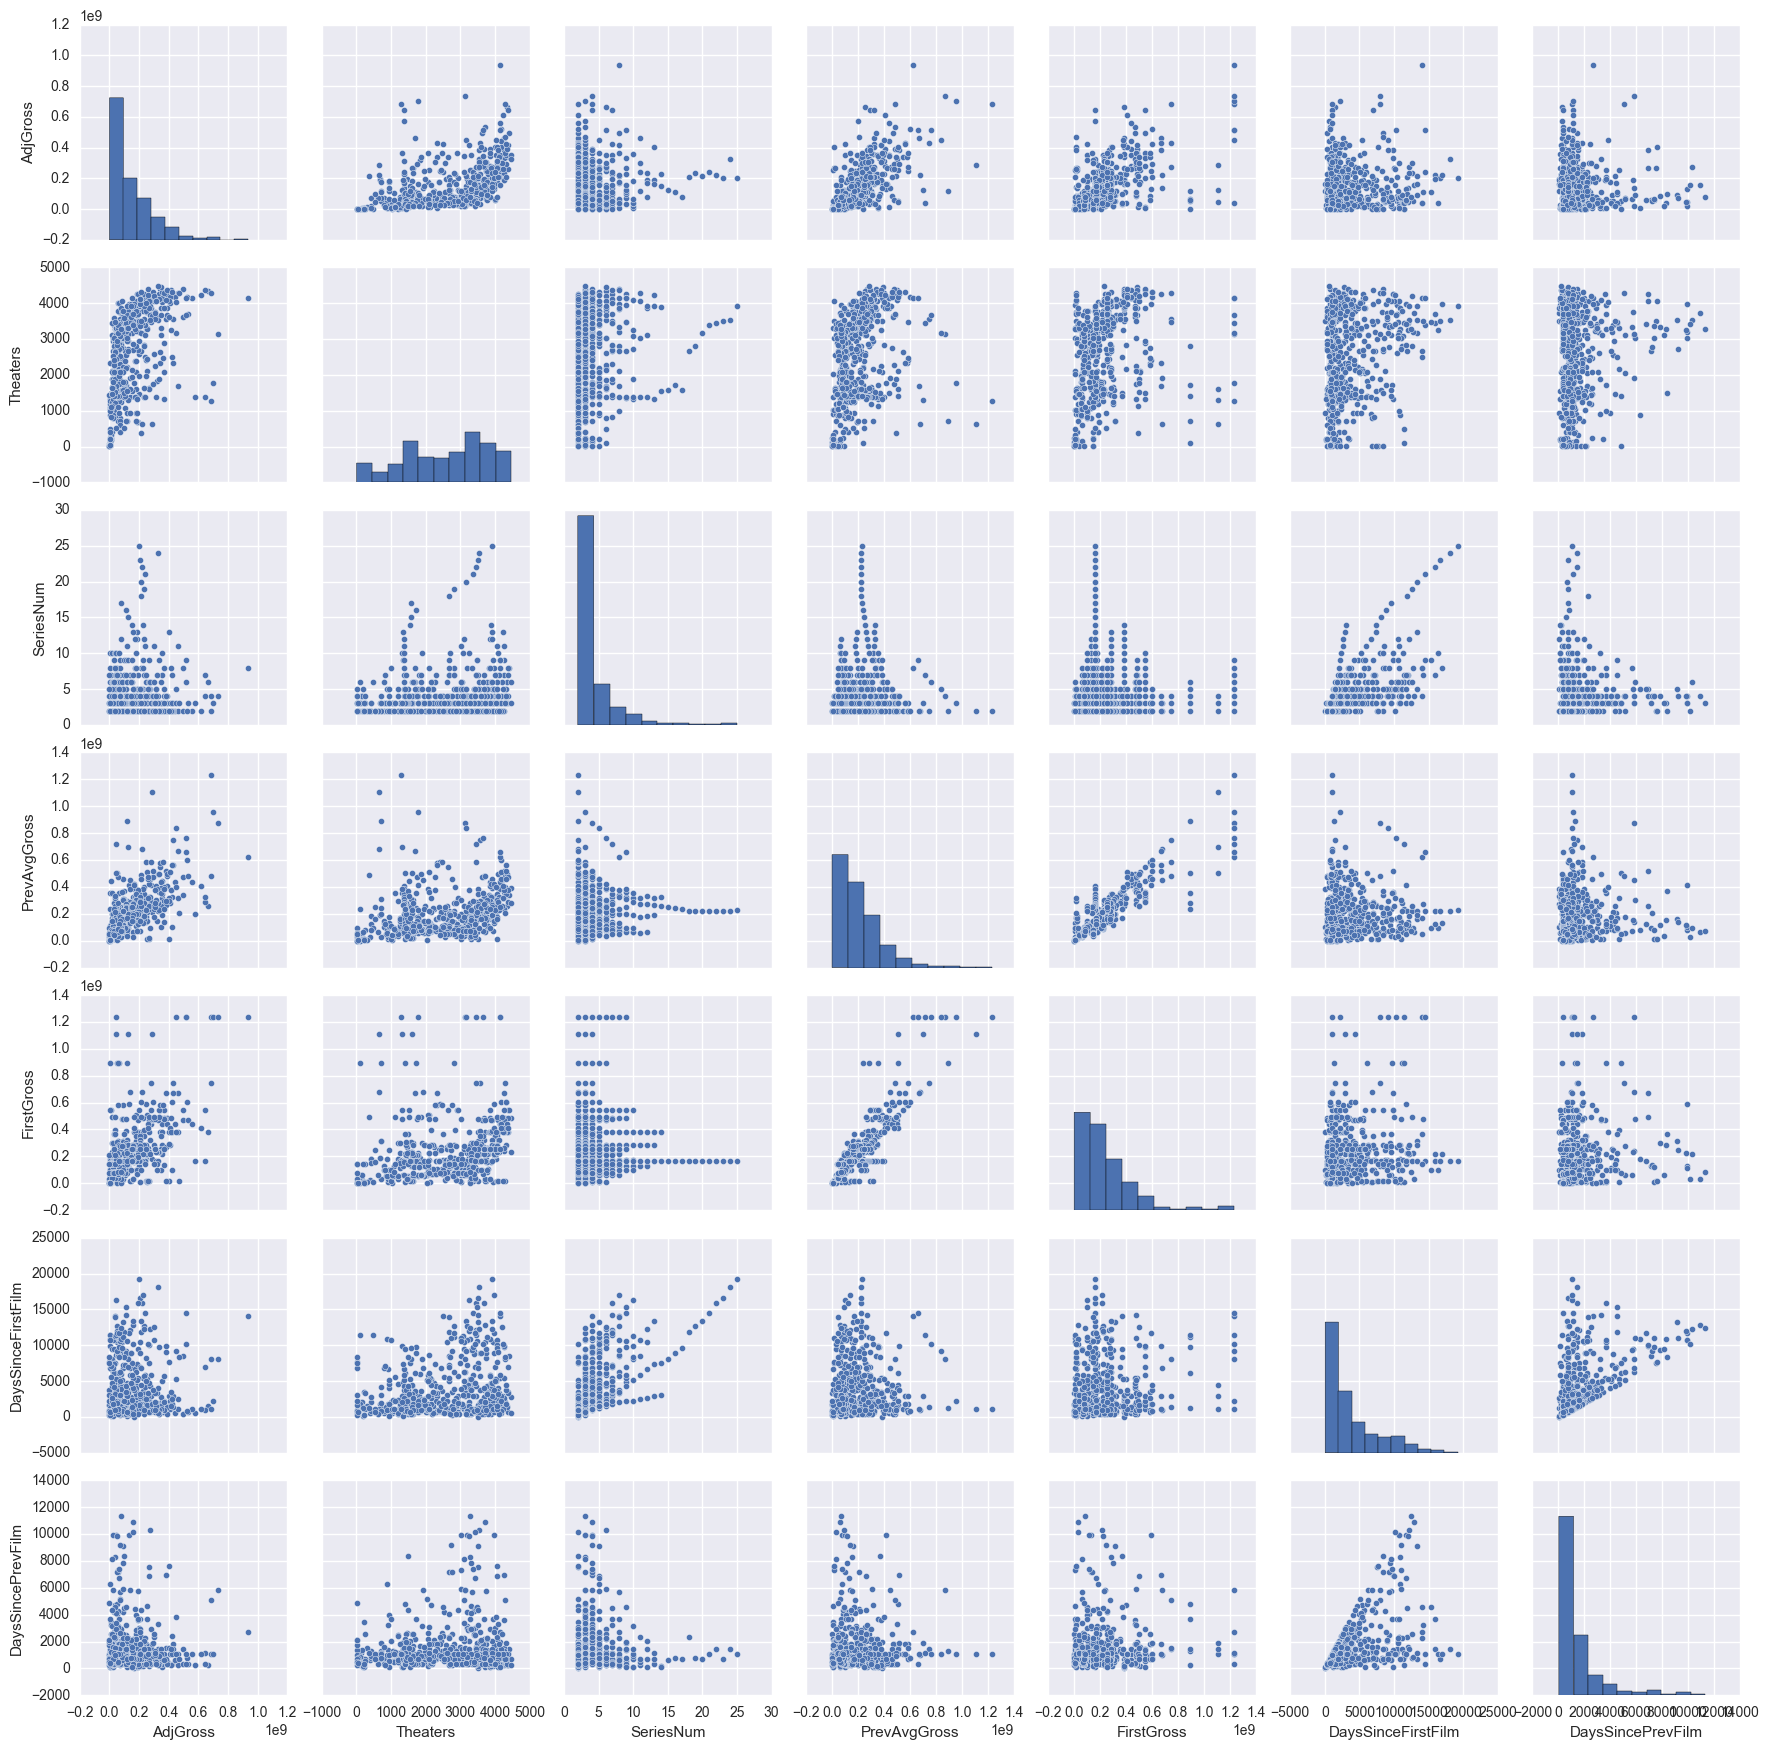

In [930]:
sns.pairplot(dfreg);

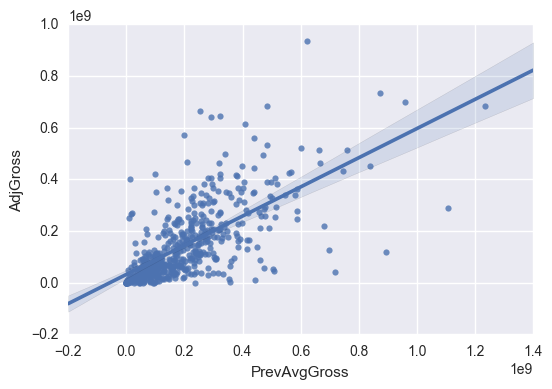

In [1031]:
sns.regplot((dfreg.PrevAvgGross), (dfreg.AdjGross));

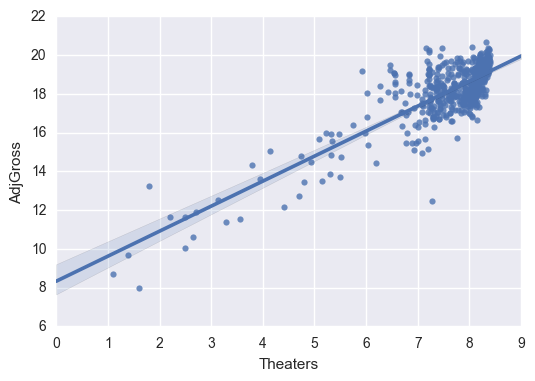

In [1032]:
sns.regplot(np.log(dfreg.Theaters), np.log(dfreg.AdjGross));

In the pairplot we can see that 'AdjGross' may have some correlation with the variables, particularly 'Theaters' and 'PrevAvgGross'. However, it looks like a polynomial model, or natural log / some other transformation will be required before fitting a linear model.

In [932]:
y, X = patsy.dmatrices('AdjGross ~ Theaters + SeriesNum + PrevAvgGross + FirstGross + DaysSinceFirstFilm + DaysSincePrevFilm', data=dfreg, return_type="dataframe")

### First try: Initial linear regression model with statsmodels

In [933]:
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               AdjGross   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     110.0
Date:                Fri, 03 Feb 2017   Prob (F-statistic):           6.00e-90
Time:                        01:15:01   Log-Likelihood:                -10685.
No. Observations:                 540   AIC:                         2.138e+04
Df Residuals:                     533   BIC:                         2.141e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept          -5.294e+07   1.16e+07     -4.569      0.000     -7.57e+07 -3.02e+07
Theaters            3.959e+04   3697.763     10.706      0.000      3.23e+04  4.69e+04
SeriesNum           3.379e+06   2.04e+06      1.657      0.098     -6.28e+05  7.39e+06
PrevAvgGross           0.5605      0.059      9.542      0.000         0.445     0.676
FirstGross            -0.0696      0.044     -1.563      0.119        -0.157     0.018
DaysSinceFirstFilm -3305.0380   2096.598     -1.576      0.116     -7423.648   813.572
DaysSincePrevFilm   -555.5438   3174.223     -0.175      0.861     -6791.066  5679.978
==============================================================================
Omnibus:                      200.379   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1093.186
Skew:                           1.542   Prob(JB):                    4.15e-238
Kurtosis:                       9.251   Cond. No.                     1.16e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

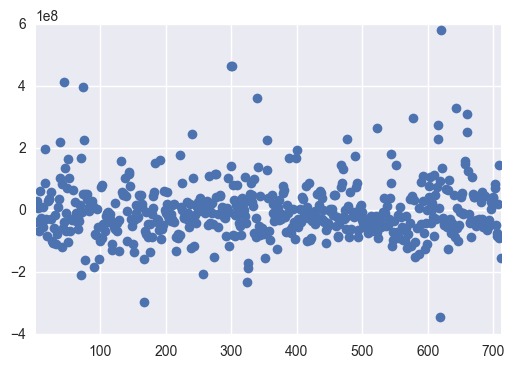

In [935]:
fit.resid.plot(style='o');

### Try Polynomial Regression

In [938]:
polyX=PolynomialFeatures(2).fit_transform(X)

In [941]:
polymodel = sm.OLS(y, polyX)
polyfit = polymodel.fit()
polyfit.rsquared

0.63917556520562635

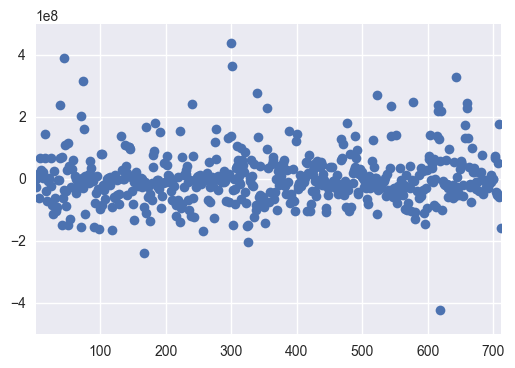

In [944]:
polyfit.resid.plot(style='o');

In [945]:
polyfit.rsquared_adj

0.62599159547275496

### Heteroskedasticity
The polynomial regression improved the Adjusted Rsquared and the residual plot, but there's still issues with other statistics including skew. It's worth running the Breusch-Pagan test:

In [947]:
hetnames = ['Lagrange multiplier statistic', 'p-val', 'f-val', 'f p-val']
hettest = sm.stats.diagnostic.het_breushpagan(fit.resid, fit.model.exog)
zip(hetnames,hettest)

[('Lagrange multiplier statistic', 59.176710277726116),
 ('p-val', 6.6143443857103e-11),
 ('f-val', 10.933048673053531),
 ('f p-val', 1.6877748201974073e-11)]

In [948]:
hetnames = ['Lagrange multiplier statistic', 'p-val', 'f-val', 'f p-val']
hettest = sm.stats.diagnostic.het_breushpagan(polyfit.resid, fit.model.exog)
zip(hetnames,hettest)

[('Lagrange multiplier statistic', 52.139634651983954),
 ('p-val', 1.7480550785765188e-09),
 ('f-val', 9.4939820364662175),
 ('f p-val', 6.3527969215406968e-10)]

### Apply Box-Cox Transformation
As seen above the p-values were very low, suggesting the data is indeed tending towards heteroskedasticity. To improve the data we can apply boxcox.

In [949]:
dfPolyX = pd.DataFrame(polyX)
bcPolyX = pd.DataFrame()
for i in range(dfPolyX.shape[1]):
    bcPolyX[i] = scipy.stats.boxcox(dfPolyX[i])[0]

In [950]:
# Transformed data with Box-Cox:
bcPolyX.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0,0.0,1379.299460,0.531850,2783.031941,1424.471172,8.468178,5.681496,0.0,1379.299460,...,0.295376,0.295376,708.740595,527.453349,0.295376,269.434349,249.287821,16.936356,14.164688,11.362993
1,0.0,0.0,42.644860,0.730508,2423.782274,1424.471172,9.142174,5.113736,0.0,42.644860,...,0.295376,0.295376,714.680386,428.916068,0.295376,286.686922,222.930067,18.284348,13.766970,10.227472
2,0.0,0.0,94.906975,0.837049,2076.549283,1424.471172,10.549185,6.115709,0.0,94.906975,...,0.295376,0.295376,774.282392,509.691665,0.295376,324.304986,272.086119,21.098369,16.290594,12.231418
3,0.0,0.0,1713.707266,0.531850,3566.276944,1775.428879,9.676846,6.211814,0.0,1713.707266,...,0.295376,0.295376,932.414623,680.430067,0.295376,332.239841,305.784512,19.353691,15.857799,12.423628
4,0.0,0.0,1693.642063,0.730508,3561.049642,1775.428879,12.425688,7.081833,0.0,1693.642063,...,0.295376,0.295376,1256.456736,853.173760,0.295376,417.250310,366.687149,24.851374,19.158201,14.163667


In [952]:
# Introduce log(y) for target variable:
y = y.reset_index(drop=True)
logy = np.log(y)

### Try Polynomial Regression again with Log Y and Box-Cox transformed X

In [965]:
logPolyModel = sm.OLS(logy, bcPolyX)
logPolyFit = logPolyModel.fit()
logPolyFit.rsquared_adj

0.82639144553295163

### Apply Regularization using Elastic Net to optimize this model.

In [974]:
X_scaled = preprocessing.scale(bcPolyX)
en_cv = linear_model.ElasticNetCV(cv=10, normalize=False)
en_cv.fit(X_scaled, logy)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [985]:
en_cv.coef_

array([ 0.        ,  0.        , -0.09778682, -0.22718488,  1.08431228,
       -0.16206495, -0.13710198,  0.2081677 ,  0.        , -0.        ,
       -0.05566614,  0.93082535, -0.46732173, -0.13935011,  0.14423405,
       -0.15442166,  0.4146195 , -0.98641762,  0.23276685,  1.56872592,
        0.75385676, -0.01684137,  0.75142965, -0.        ,  0.3142132 ,
       -0.73205773,  0.        ,  0.        , -1.00683123, -0.37426653,
        0.        ,  0.22524441, -0.06747595, -0.75438376, -0.        ,
        0.11161417])

In [983]:
logy_en = en_cv.predict(X_scaled)
mse = metrics.mean_squared_error(logy, logy_en)

In [984]:
# The mean square error for this model
mse

0.56136484446836377

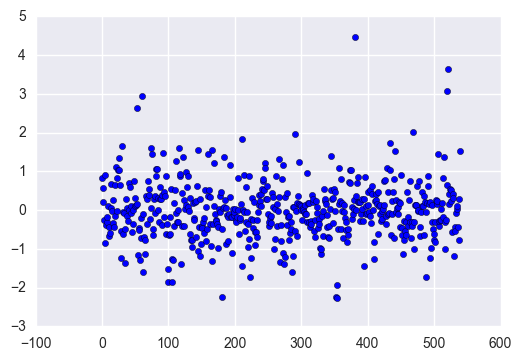

In [1069]:
plt.scatter([x for x in range(540)],(pd.DataFrame(logy_en)[0] - logy['AdjGross']));

## Step 4
As seen above, Polynomial Regression with Elastic Net produces a model with several nonzero coefficients for the given features. I decided to try testing this model on the three new sequels for 2017.

In [1004]:
films17

,Title,Franchise,AdjGross,Release,Theaters,CumGross,SeriesNum,PrevAvgGross,PrevRelease,NumOfFilms,FirstGross,FirstRelease,SumTheaters,AvgTheaters,DaysSinceFirstFilm,DaysSincePrevFilm
530,Resident Evil: The Final Chapter,./chart/?id=residentevil.htm,16634600,2017-01-27,3104.0,323867200,6.0,61446520.0,2012-09-14,6,59730700,2002-03-15,17989,2998.166667,5432,1596
712,xXx: The Return of Xander Cage,./chart/?id=xxxtrilogy.htm,35814600,2017-01-20,3651.0,283638200,3.0,123911800.0,2005-04-29,3,211558500,2002-08-09,10667,3555.666667,5278,4284
676,Underworld: Blood Wars,./chart/?id=underworld.htm,29756100,2017-01-06,3070.0,308546300,5.0,69697550.0,2012-01-20,5,74535000,2003-09-19,15225,3045.000000,4858,1813


In [992]:
df17 = films17[['AdjGross','Theaters','SeriesNum','PrevAvgGross','FirstGross','DaysSinceFirstFilm','DaysSincePrevFilm']]
y17, X17 = patsy.dmatrices('AdjGross ~ Theaters + SeriesNum + PrevAvgGross + FirstGross + DaysSinceFirstFilm + DaysSincePrevFilm', data=df17, return_type="dataframe")
polyX17 = PolynomialFeatures(2).fit_transform(X17)

dfPolyX17 = pd.DataFrame(polyX17)
bcPolyX17 = pd.DataFrame()
for i in range(dfPolyX17.shape[1]):
    bcPolyX17[i] = scipy.stats.boxcox(dfPolyX17[i])[0]
X17_scaled = preprocessing.scale(bcPolyX17)

In [993]:
# Run the "en_cv" model from above on the 2017 data:
logy_en_2017 = en_cv.predict(X17_scaled)

In [1005]:
# Predicted Adjusted Gross:
pd.DataFrame(np.exp(logy_en_2017))

,0
0,3.550723e+06
1,7.522682e+08
2,1.496257e+08


In [1002]:
# Adjusted Gross as of 2/1:
y17

,AdjGross
530,16634600.0
712,35814600.0
676,29756100.0
